# Titanic

In this project, we predict the "death" or "survival" of Titanic's passengers, it's then a classification problem that we solve here ... Several methods may be used, in our case we chose to apply 4 algorithms :

* Logistic Regression 
* Support Vector Machine
* Random Forest
* Decision Tree

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
t_train = pd.read_csv('train.csv')
t_test = pd.read_csv('test.csv')
ytest = pd.read_csv('gender_submission.csv')

In [3]:
t_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

#### It's clear that some of the above varibles do absolutely have any impact on one's chance to survive while 'Sex', 'Age' and 'Pclass' seem to be the main factors that determine the fate of a traveler.

* We expect men to sacrifice their lives to save women (like in the movie !)
* The parents will give way to their children in the rescue boats and the young will do the same for the old ones..
* Wealthy people who could afford a P1 class ticket will take place first in the rescue boats, followed by medium class travelers who bought a P2 class ticket, and then, the miserable ones who have a P3 ticket (if there are still some places for them !)

We will then explain the Boolean variable 'Survived' via 'Sex', 'Age' and 'Pclass'

In [4]:
t1 = t_train[['Sex', 'Pclass', 'Age','Survived']]
z1 = t_test[['Sex', 'Pclass', 'Age']]

In [5]:
t1.head()

,Sex,Pclass,Age,Survived
0,male,3,22.0,0
1,female,1,38.0,1
2,female,3,26.0,1
3,female,1,35.0,1
4,male,3,35.0,0


In [6]:
t1.count()

Sex         891
Pclass      891
Age         714
Survived    891
dtype: int64

#### We notice that some values are missing in the 'Age' column. In order to fix it :

* One may drop them, but in this case, he will lose 20% of data
* A second option consist in filling them with a sample having the same distribution as this of the available values, but we will see that this one can't be approached by any one of the "usual" probability laws


* The mean 'Age' is 29.7 and the standard deviation is 14.53 so that the coefficient of variation is about 0.5, so the coefficient is excellent and the series is well concentrated around the average. That's why we will replace the NaN with the MEAN.

In [7]:
tna = t1['Age'].fillna(t1['Age'].mean())
t2 = t1[['Sex', 'Pclass','Survived']]
t2['Age'] = tna
t2 = t2[['Sex', 'Pclass','Age','Survived']]

# On prépare les données du test en parallèle

zna = z1['Age'].fillna(t1['Age'].mean())
z2 = z1[['Sex', 'Pclass']]
z2['Age'] = zna
z2['Survived'] = ytest['Survived']

In [8]:
z2.head()

,Sex,Pclass,Age,Survived
0,male,3,34.5,0
1,female,3,47.0,1
2,male,2,62.0,0
3,male,3,27.0,0
4,female,3,22.0,1


In [9]:
t2.count()

Sex         891
Pclass      891
Age         891
Survived    891
dtype: int64

In [10]:
t2.isnull().sum(axis = 0)

Sex         0
Pclass      0
Age         0
Survived    0
dtype: int64

In [11]:
tc = t1.groupby('Pclass').Survived.value_counts()
tc

Pclass  Survived
1       1           136
        0            80
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

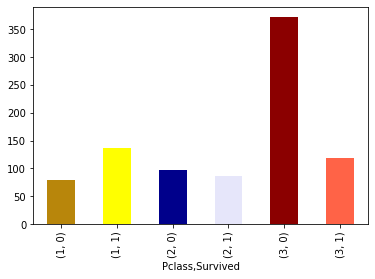

In [12]:
X1 = [(1,0),(1,1),(2,0),(2,1),(3,0),(3,1)]
tc.reindex(X1).plot.bar(color=['darkgoldenrod','yellow','darkblue','lavender','darkred','tomato'])
plt.show()

The above figure shows clearly - as expected - the relationship between the Class of the passenger and his chance to survive, then:

* There are more survivors than dead in the first class (left)
* There are almost as many lucky as unlucky ones in the second class (center)
* The gap is huge between dead and survivors in the third class where the number of victims is about four times the one of the second class

In [13]:
ts = t1.groupby('Sex').Survived.value_counts()
ts

Sex     Survived
female  1           233
        0            81
male    0           468
        1           109
Name: Survived, dtype: int64

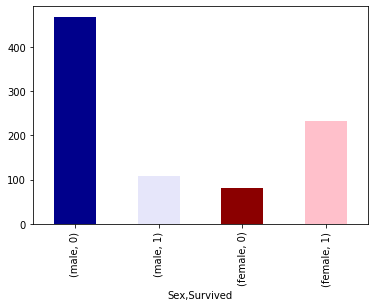

In [14]:
X2 = [('male',0),('male',1),('female',0),('female',1)]

ts.reindex(X2).plot(kind='bar', color=['darkblue','lavender','darkred','pink'])
plt.show()

This figure shows also that for 4 dead men there is only one survivor, while only one woman 4 perished in this disaster.

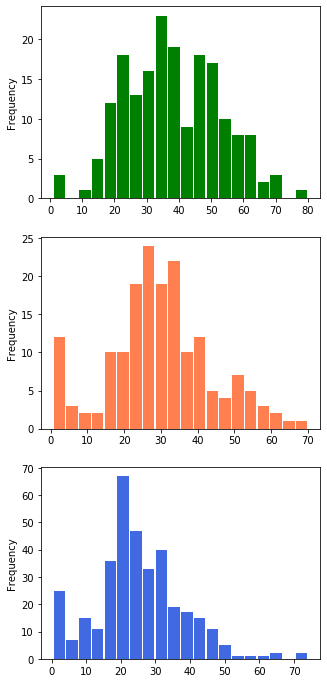

In [15]:
fig, axes = plt.subplots(figsize=(5,12), nrows=3, ncols=1)
t1[(t1['Pclass']==1)].Age.plot.hist(ax=axes[0], grid=False, bins=20, rwidth=0.9, color='green')
t1[(t1['Pclass']==2)].Age.plot.hist(ax=axes[1], grid=False, bins=20, rwidth=0.9, color='coral')
t1[(t1['Pclass']==3)].Age.plot.hist(ax=axes[2], grid=False, bins=20, rwidth=0.9, color='royalblue')

These figures let us predict the existence of a relationship between the age of the travelers and the class they have chosen. 
This relationship is much clearer on the next figure where we use seaborn to present the density of the three series.

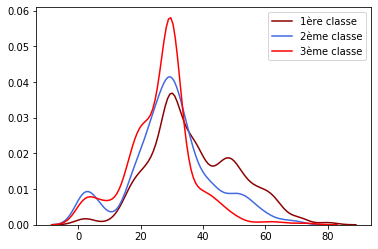

In [16]:
import seaborn as sns
sns.kdeplot(t2.Age[t2.Pclass == 1], bw=3, color='darkred')
sns.kdeplot(t2.Age[t2.Pclass == 2], bw=3, color='royalblue')
sns.kdeplot(t2.Age[t2.Pclass == 3], bw=3, color='red')
plt.legend(('1ère classe','2ème classe','3ème classe'))

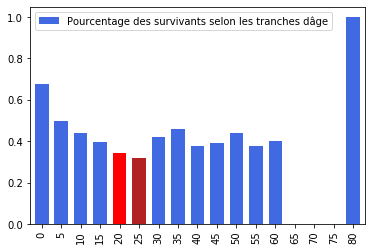

In [17]:
def surv_age(j):
    v = t2[(t2['Age'] >= j*5) & (t2['Age'] < (j+1)*5)].Survived.mean()
    return v

from matplotlib.pyplot import *
X = [i for i in range(17)]
Y = [surv_age(i) for i in X]
X = [i*5 for i in range(17)]

C = ['royalblue']*14
C[4] = 'red'
C[5] = 'firebrick'

fig, ax = subplots()
TT = pd.DataFrame(Y,index=X)
TT.plot(kind='bar',width=0.7, color=[C], ax=ax)
ax.legend(["Pourcentage des survivants selon les tranches dâge"]);

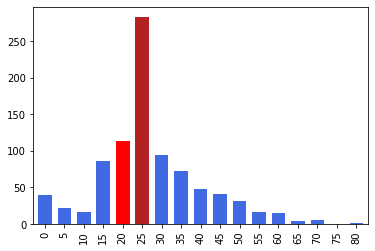

In [18]:
def count_age(j):
    v = t1[(t2['Age'] >= j*5) & (t2['Age'] < (j+1)*5)].Survived.count()
    return v

X = [i for i in range(17)]
Y = [count_age(i) for i in X]
X = [i*5 for i in range(17)]

C = ['royalblue']*14
C[4] = 'red'
C[5] = 'firebrick'

fig, ax = subplots()
TT2 = pd.DataFrame(Y,index=X)
TT2.plot(kind='bar',width=0.7, ax=ax, color=[C], legend=False)

The two latest figures show that:

* People being between 20 and 29 are the ones who have less chance to survive, given that thses two classes are the largest ones.
* The class [25, 29] is the largest one because it includes the mean age, then, the values we added to the dateset. However it remains the largest one even if we remove them.
* Kids under 10 were the luckiest ones among all the passengers 
* the oldest person who was 80 was saved and it was a man.
* Among travelers whose age is initially known, none were between 75 and 79 years old while all travelers between 65 and 74, and who were all men, drowned, and the they were 10 men.

In [19]:
R = np.zeros(len(t2.Sex))
S = np.zeros(len(z2.Sex))

for i in range(len(t2.Sex)):
    if t2.Sex[i] == 'female':
        R[i] = 1
    elif t2.Sex[i] == 'male':
        R[i] = 0
        
for i in range(len(z2.Sex)):
    if z2.Sex[i] == 'female':
        S[i] = 1
    elif t2.Sex[i] == 'male':
        S[i] = 0

R = pd.Series(R)
S = pd.Series(S)

t2.Sex = R
z2.Sex = S

t2['Sex'] = t2['Sex'].astype(int)
z2['Sex'] = z2['Sex'].astype(int)

t2.head()

,Sex,Pclass,Age,Survived
0,0,3,22.0,0
1,1,1,38.0,1
2,1,3,26.0,1
3,1,1,35.0,1
4,0,3,35.0,0


In [20]:
ytrain = t2.Survived.values
xtrain = t2[['Pclass','Age','Sex']].values

ytest = z2.Survived.values
xtest = z2[['Pclass','Age','Sex']].values

#### The first method used in ths work is the Logistic Regression with the Broyden–Fletcher–Goldfarb–Shanno algorithm aka lbfgs.

In [21]:
from sklearn import linear_model

LR = linear_model.LogisticRegression(solver='lbfgs')
model1 = LR.fit(xtrain,ytrain)

0.8002244668911336


In [22]:
ypred1 = LR.predict(xtest)

M1 = sklearn.metrics.precision_recall_fscore_support(ytest, ypred1) #, average='binary')

print(M1)

(array([0.96981132, 0.94117647]), array([0.96616541, 0.94736842]), array([0.96798493, 0.9442623 ]), array([266, 152], dtype=int64))


#### The second method which is the SVM is a classification method too. In the case of a Boolean variable, it divides the space into two parts with a hyperplane

In [23]:
from sklearn import svm

SVM = svm.LinearSVC(max_iter=200000)
model2 = SVM.fit(xtrain,ytrain)

In [24]:
ypred2 = SVM.predict(xtest)

M2 = sklearn.metrics.precision_recall_fscore_support(ytest, ypred2) #, average='binary')

print(M2)

(array([0.9887218 , 0.98026316]), array([0.9887218 , 0.98026316]), array([0.9887218 , 0.98026316]), array([266, 152], dtype=int64))


#### Now, we apply the Random Forest algorithm

In [25]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=20, random_state=0)
model3 = RF.fit(xtrain,ytrain)

In [26]:
ypred3 = RF.predict(xtest)

M3 = sklearn.metrics.precision_recall_fscore_support(ytest, ypred3) #, average='binary')

print(M3)

(array([0.90384615, 0.80379747]), array([0.88345865, 0.83552632]), array([0.89353612, 0.81935484]), array([266, 152], dtype=int64))


#### The last method used in this project is the Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
model4 = DT.fit(xtrain,ytrain)

In [28]:
ypred4 = DT.predict(xtest)

M4 = sklearn.metrics.precision_recall_fscore_support(ytest, ypred4) #, average='binary')

print(M4)

(array([0.89097744, 0.80921053]), array([0.89097744, 0.80921053]), array([0.89097744, 0.80921053]), array([266, 152], dtype=int64))


_________________________________________________________________________
_________________________________________________________________________
_________________________________________________________________________
#### In this work, 4 methods have been used to solve a classification problem, the performance of each of them has been measured by using three metrics: RECALL, PRECISION, and F1 SCORE and the results are given for both classes (positive and negative) trough M1, M2, M3 and M4

#### The best results are provided by the SVM followed by the Logistic Regression, those ones are much better than those of the Random Forest and the Decision Tree

#### The SVM is computationally much more expensive than the others, indeed, it required about 200000 iterations to converge and at 190000 iterations it shows a warning message about the convergence.